#  Fashion-MNIST dataset:

## Label	Description :
 - 0:	T-shirt/top
 - 1	Trouser
 - 2	Pullover
 - 3	Dress
 - 4	Coat
 - 5	Sandal
 - 6	Shirt
 - 7	Sneaker
 - 8	Bag
 - 9	Ankle boot
 
 
 Source: github.com/zalandoresearch/fashion-mnist

# Let's display a sneaker:

In [1]:
#I like my cells wide and proud
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Review the resources landscape:
```
!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
```

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import xrange
import logging
import os
###########################
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval, tf_model_load
from cleverhans_tutorials.tutorial_models import make_basic_cnn,make_fmnist_cnn

```
def make_basic_cnn(nb_filters=64, nb_classes=10,
                   input_shape=(None, 28, 28, 1)):
    layers = [Conv2D(nb_filters, (8, 8), (2, 2), "SAME"),
              ReLU(),
              Conv2D(nb_filters * 2, (6, 6), (2, 2), "VALID"),
              ReLU(),
              Conv2D(nb_filters * 2, (5, 5), (1, 1), "VALID"),
              ReLU(),
              Flatten(),
              Linear(nb_classes),
              Softmax()]

    model = MLP(layers, input_shape)
    return model
```

In [3]:
import tensorflow as tf
print(tf.__version__)
import cleverhans
cleverhans.__version__

1.2.1


'2.0.0-7f7f9b18a1988fdf6d37d5c40deabae6'

# Initialize the parameters as per:
https://github.com/tensorflow/cleverhans/blob/b8d15f3d7b6f820f812087512b60d9675cb431eb/cleverhans_tutorials/mnist_tutorial_cw.py

# Model definition:

In [4]:
!nvidia-smi

Wed Nov  1 06:47:39 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 381.22                 Driver Version: 381.22                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 0000:02:00.0     Off |                  N/A |
|  0%   46C    P8    16W / 250W |    159MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 0000:03:00.0     Off |                  N/A |
| 23%   35C    P8    17W / 250W |   4297MiB / 12187MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

Created TensorFlow session.


Using TensorFlow backend.


7
Defined TensorFlow model graph.


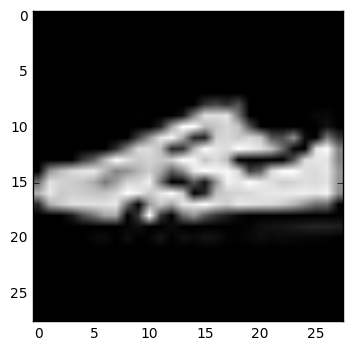

In [5]:
# MNIST-specific dimensions
img_rows = 28
img_cols = 28
channels = 1

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# # Create TF session
# tf.device("/gpu:0")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.666), 
                                                 device_count={'CPU':2, 'GPU':1}))
print("Created TensorFlow session.")
set_log_level(logging.DEBUG)

# Get MNIST test data
# X_train, Y_train, X_test, Y_test = data_mnist(train_start=train_start,
#                                               train_end=train_end,
#                                               test_start=test_start,
#                                               test_end=test_end)

import os
import sys

sys.path.append(os.path.join(os.getcwd(),'fashion_mnist'))
from utils import mnist_reader
X_train_vec, y_train_vec = mnist_reader.load_mnist('data/fashion', kind='train')
X_test_vec, y_test_vec = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train_vec = X_train_vec.astype('float32')
X_test_vec = X_test_vec.astype('float32')
X_train_vec /= 255
X_test_vec /= 255
from keras.utils import np_utils
X_train=X_train_vec.reshape(60000,28,28,1)
X_test=X_test_vec.reshape(10000,28,28,1)
Y_train=np_utils.to_categorical(y_train_vec, num_classes=10)
Y_test=np_utils.to_categorical(y_test_vec, num_classes=10)
#Let's display a sneaker:

%matplotlib inline
plt.imshow(X_test[2143,:,:,0],cmap='gray')
print(np.argmax(Y_test[2143]))
nb_classes=10

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

# Define TF model graph
model = make_basic_cnn()
# model = make_fmnist_cnn()
preds = model(x)
print("Defined TensorFlow model graph.")


###########################################################################
# Training the model using TensorFlow
###########################################################################

In [6]:
#     :param viz_enabled: (boolean) activate plots of adversarial examples
#     :param nb_epochs: number of epochs to train model
#     :param batch_size: size of training batches
#     :param nb_classes: number of output classes
#     :param source_samples: number of test inputs to attack
#     :param learning_rate: learning rate for training
#     :param model_path: path to the model file
#     :param targeted: should we run a targeted attack? or untargeted?
viz_enabled=True
nb_epochs=10
batch_size=128
nb_classes=10
source_samples=10
learning_rate=0.001
attack_iterations=100
targeted=True
DIM_EMBEDDING=9
DIM_MATRIX=5
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

In [7]:
# Train an MNIST model
train_params = {
    'nb_epochs': nb_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate
}

rng = np.random.RandomState([2017,10, 31])
# check if we've trained before, and if we have, use that pre-trained model
# if os.path.exists(model_path + ".meta"):
#     print('Pre-trained!')
#     tf_model_load(sess, model_path)
# else:
model_train(sess, x, y, preds, X_train, Y_train, args=train_params,
                save=os.path.exists("models"), rng=rng)

# Evaluate the accuracy of the MNIST model on legitimate test examples
eval_params = {'batch_size': batch_size}
accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
assert X_test.shape[0] == 10000, X_test.shape
print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
report.clean_train_clean_eval = accuracy

[INFO 2017-11-01 06:47:44,624 cleverhans] Epoch 0 took 2.16934990883 seconds
[INFO 2017-11-01 06:47:46,450 cleverhans] Epoch 1 took 1.8176548481 seconds
[INFO 2017-11-01 06:47:48,269 cleverhans] Epoch 2 took 1.80719900131 seconds
[INFO 2017-11-01 06:47:50,098 cleverhans] Epoch 3 took 1.81748986244 seconds
[INFO 2017-11-01 06:47:51,977 cleverhans] Epoch 4 took 1.86765599251 seconds
[INFO 2017-11-01 06:47:53,801 cleverhans] Epoch 5 took 1.81340098381 seconds
[INFO 2017-11-01 06:47:55,636 cleverhans] Epoch 6 took 1.82230305672 seconds
[INFO 2017-11-01 06:47:57,469 cleverhans] Epoch 7 took 1.82381796837 seconds
[INFO 2017-11-01 06:47:59,335 cleverhans] Epoch 8 took 1.8533809185 seconds
[INFO 2017-11-01 06:48:01,165 cleverhans] Epoch 9 took 1.8197350502 seconds
[INFO 2017-11-01 06:48:01,166 cleverhans] Completed model training.


Test accuracy on legitimate test examples: 0.9111


# Let's pick 10 legit examples to target:

Crafting 10 * 9 adversarial examples


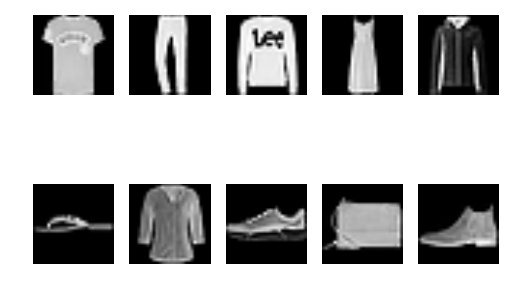

In [8]:
nb_adv_per_sample = str(nb_classes - 1)
print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample + ' adversarial examples')
###########################################################################

assert source_samples == nb_classes
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]
# [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
# Pick the first appearances of the 9 numbers in X_test
for i,idx in enumerate(idxs):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,:,:,0],cmap='gray')
    plt.axis('off')


# Create adv samples using the Carlini-L2 attack:

In [9]:
# Form a 10 x 10 array of the inputs that you seek to target:
adv_inputs = np.array([[instance] * nb_classes for instance in X_test[idxs]],dtype=np.float32)
adv_inputs = adv_inputs.reshape((source_samples * nb_classes, img_rows, img_cols, 1))


one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1



adv_ys = np.array([one_hot] * source_samples,dtype=np.float32).reshape((source_samples * nb_classes, nb_classes))
# yname = "y_target"
# Instantiate a CW attack object
cw = CarliniWagnerL2(model, back='tf', sess=sess)
cw_params = {'binary_search_steps':4,
             'y_target': adv_ys,
             'max_iterations': 5000,
             'learning_rate': 0.01,
             'batch_size': source_samples * nb_classes if
             targeted else source_samples,
             'initial_const': 0.005}

adv = cw.generate_np(adv_inputs, **cw_params)

[INFO 2017-11-01 06:48:01,985 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2017-11-01 06:48:02,260 cleverhans] Running CWL2 attack on instance 0 of 100
[DEBUG 2017-11-01 06:48:02,274 cleverhans]   Binary search step 0 of 4
[DEBUG 2017-11-01 06:48:02,348 cleverhans]     Iteration 0 of 5000: loss=11.2 l2=0 f=-6.08
[DEBUG 2017-11-01 06:48:05,652 cleverhans]     Iteration 500 of 5000: loss=10.7 l2=0.00415 f=-5.92
[DEBUG 2017-11-01 06:48:08,264 cleverhans]     Iteration 1000 of 5000: loss=10.7 l2=0.00427 f=-5.92
[DEBUG 2017-11-01 06:48:10,617 cleverhans]     Iteration 1500 of 5000: loss=10.7 l2=0.00427 f=-5.92
[DEBUG 2017-11-01 06:48:10,618 cleverhans]     Failed to make progress; stop early
[DEBUG 2017-11-01 06:48:10,619 cleverhans]   Successfully generated adversarial examples on 10 of 100 instances.
[DEBUG 2017-11-01 06:48:10,620 cleverhans]    Mean successful distortion: 0
[DEBUG 2017-11-01 06:48:10,621 cleverhans]   Binary search step 1 of 4
[DEBUG 2017-11-01 06

# Now, how good were these adv examples?

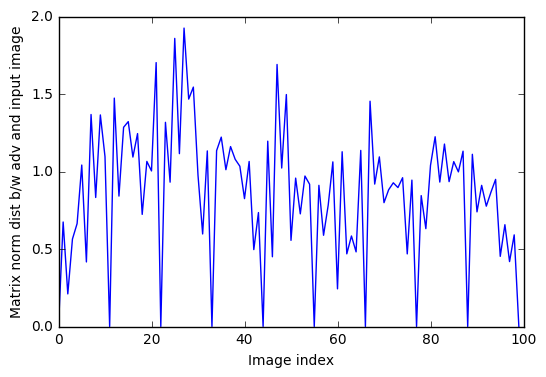

In [10]:
dev=np.zeros(100)
for i in range(100):
    dev[i]=np.linalg.norm(np.abs(adv[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [11]:
eval_params = {'batch_size': np.minimum(nb_classes, source_samples)}
adv_accuracy = model_eval(sess, x, y, preds, adv, adv_ys, args=eval_params)

# Initialize our array for grid visualization
grid_shape = (nb_classes, nb_classes, img_rows, img_cols, channels)
grid_viz_data = np.zeros(grid_shape, dtype='f')

for j in range(nb_classes):
    for i in range(nb_classes):
        grid_viz_data[i, j] = adv[i * nb_classes + j]


print(grid_viz_data.shape)

print('--------------------------------------')

# Compute the number of adversarial examples that were successfully found
print('Avg. rate of successful adv. examples {0:.4f}'.format(adv_accuracy))
report.clean_train_adv_eval = 1. - adv_accuracy

# Compute the average distortion introduced by the algorithm
percent_perturbed = np.mean(np.sum((adv - adv_inputs)**2,
                                   axis=(1, 2, 3))**.5)
print('Avg. L_2 norm of perturbations {0:.4f}'.format(percent_perturbed))

# Close TF session
sess.close()

(10, 10, 28, 28, 1)
--------------------------------------
Avg. rate of successful adv. examples 1.0000
Avg. L_2 norm of perturbations 0.8677


In [12]:
report.__dict__

{'adv_train_adv_eval': 0.0,
 'adv_train_clean_eval': 0.0,
 'clean_train_adv_eval': 0.0,
 'clean_train_clean_eval': 0.91110000000000002,
 'train_adv_train_adv_eval': 0.0,
 'train_adv_train_clean_eval': 0.0,
 'train_clean_train_adv_eval': 0.0,
 'train_clean_train_clean_eval': 0.0}

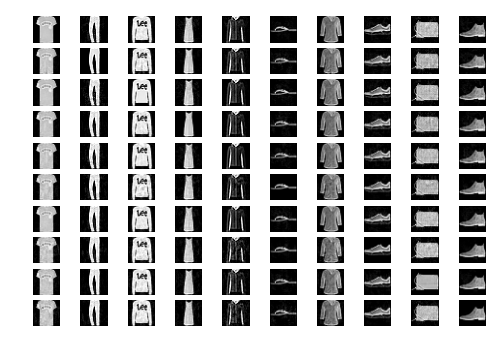

In [13]:
# Finally, block & display a grid of all the adversarial examples
_ = grid_visual(grid_viz_data)
plt.savefig('grid_fmnist.eps')

# Here begins the Lyapunov exponent based defense:

In [14]:
from nolds import lyap_e

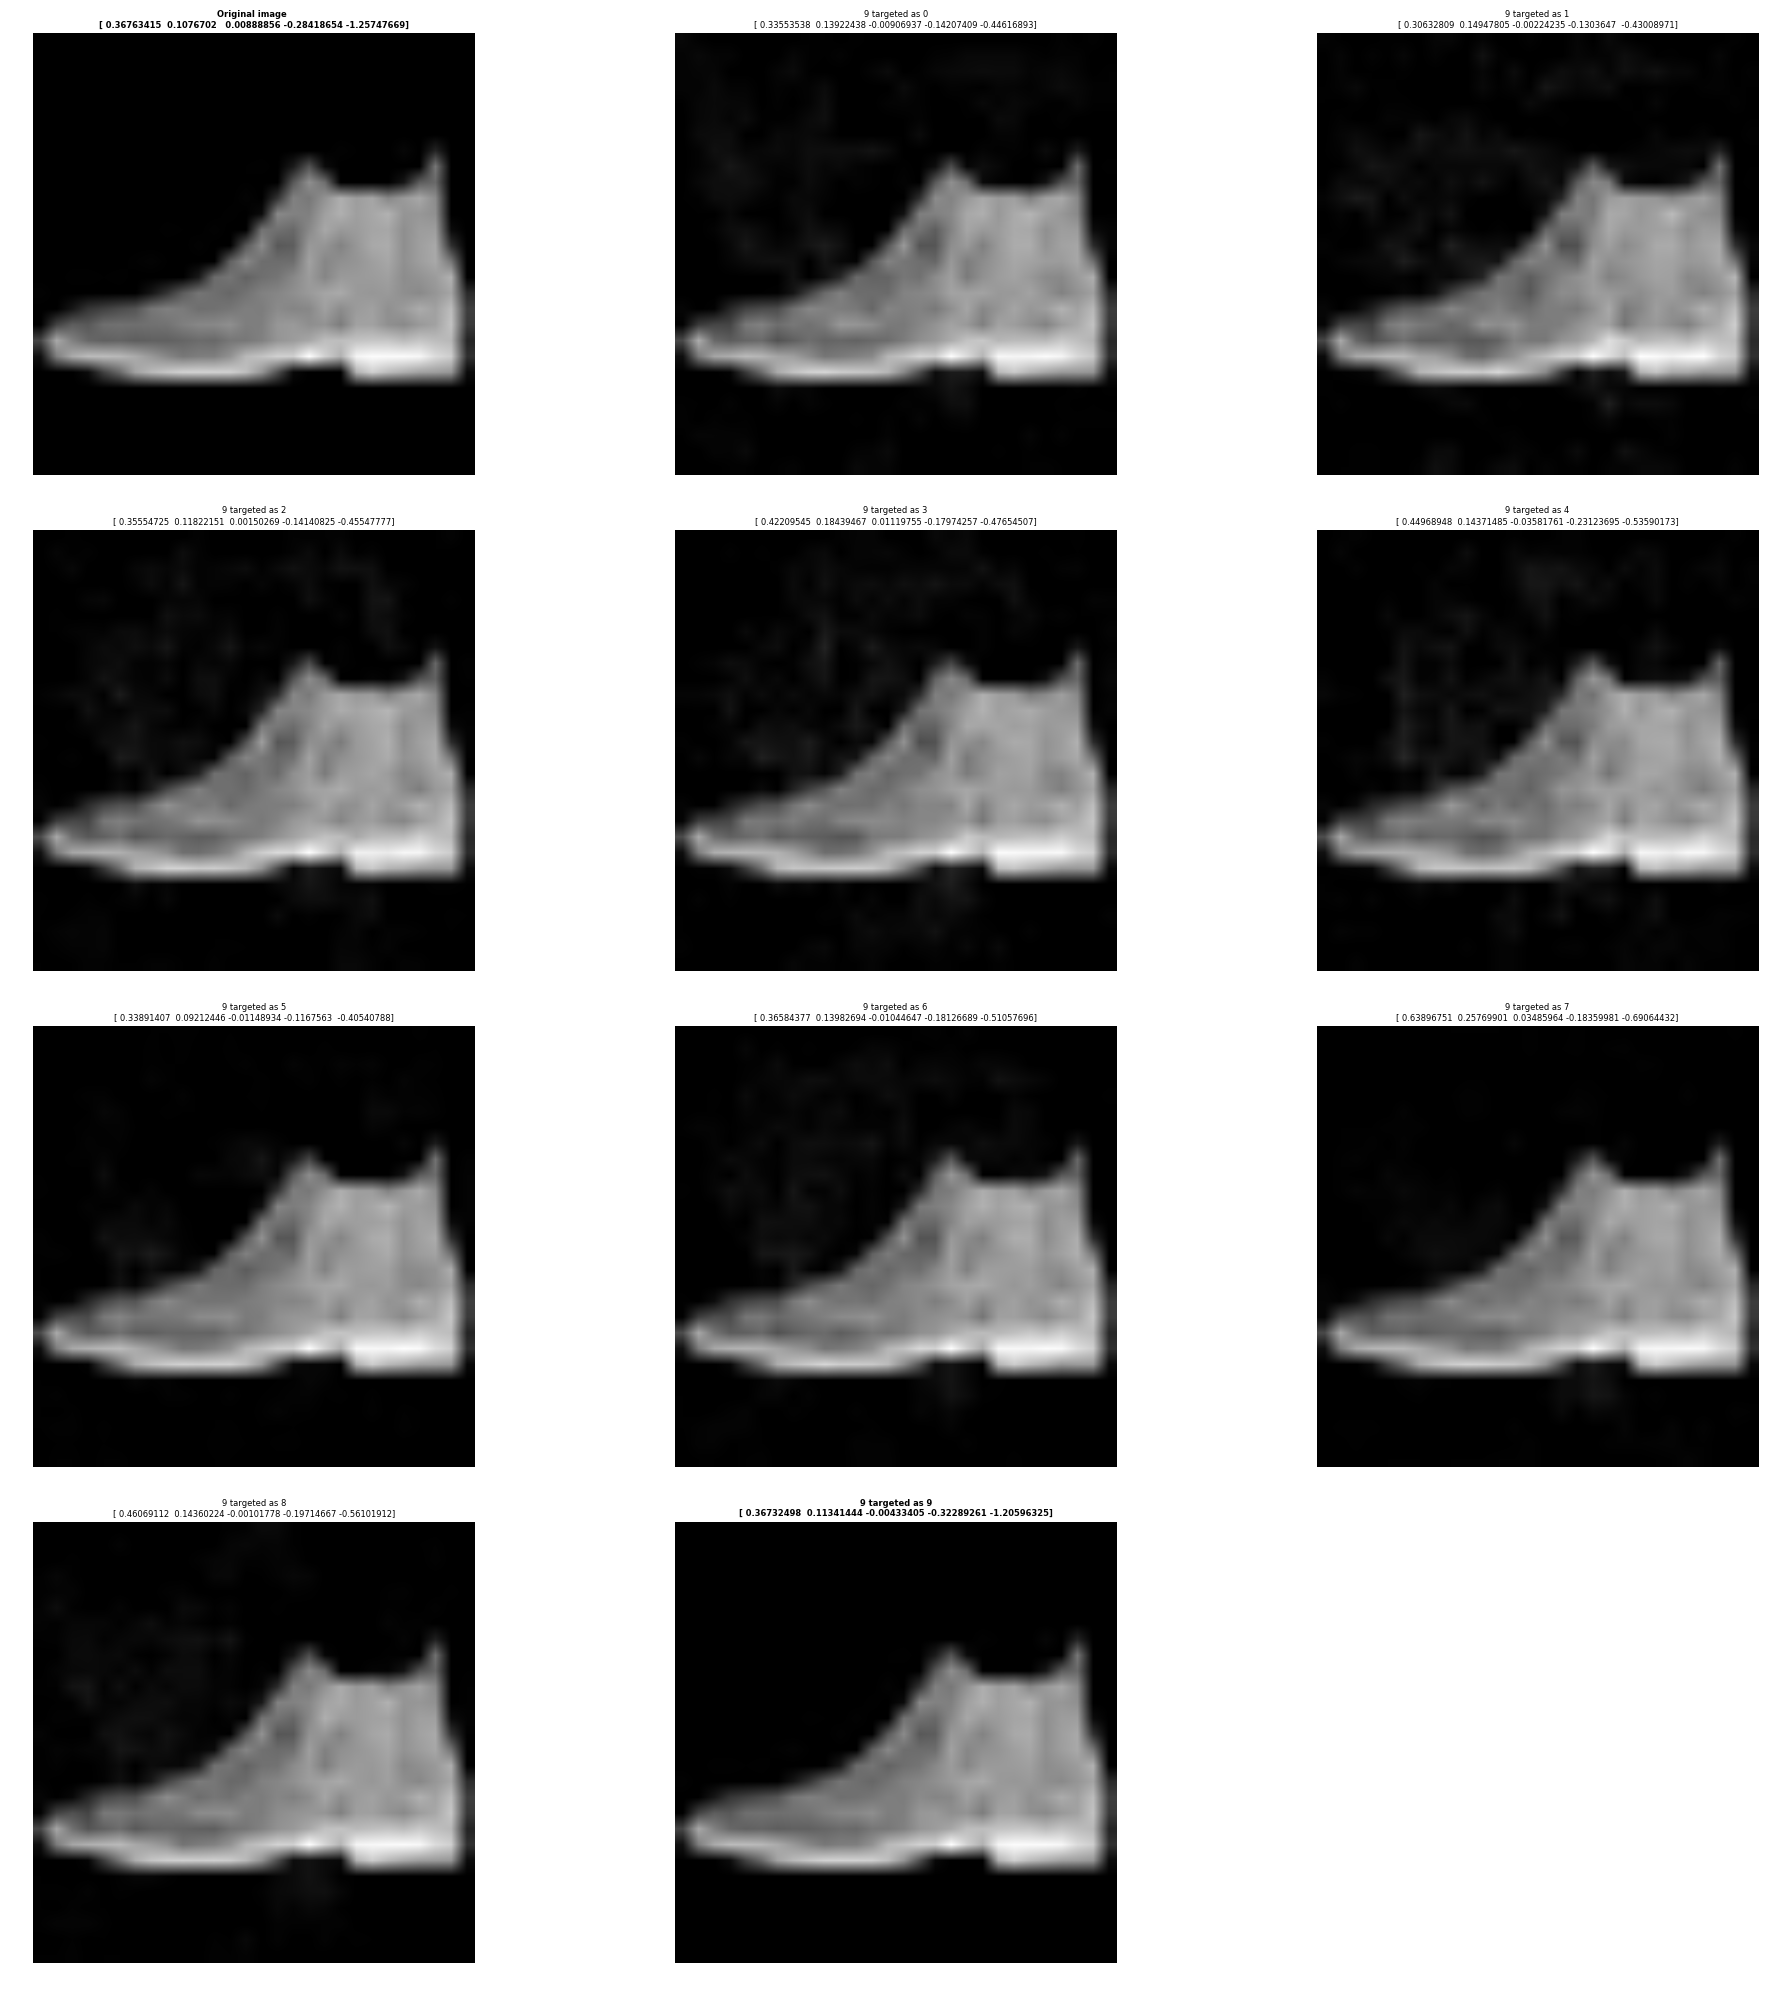

In [15]:
plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
plt.imshow(X_test[idxs[9],:,:,0],cmap='gray');
plt.axis('off');
plt.title('Original image \n'+str(lyap_e(X_test[idxs[9],:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX,)),fontweight='bold',fontsize=6)


for i in range(10):
    plt.subplot(4,3,i+2)
    plt.imshow(grid_viz_data[9,i,:,:,0],cmap='gray')
    if(i==9):
        plt.title('9 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[9,i,:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX,)),fontweight='bold',fontsize=6)
         
         
    else:
        plt.title('9 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[9,i,:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX,)),fontsize=6)
    plt.axis('off')

plt.tight_layout()
plt.savefig('ex_9.eps')

In [16]:
from tqdm import tqdm

# Visualizing the embeddings:

In [17]:
from sklearn import manifold
from time import time
from scipy.misc import imresize

###########################################################
from matplotlib import offsetbox
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding_2(X,y,image_display, title=None,file_name='fig.eps'):
    """
    print(X.shape,y.shape,digits.images.shape)
    ((N, 2), (N,), (N, 8, 8))
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-11:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            img_i = imresize(image_display[i], (7, 7))
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img_i, cmap=plt.cm.gray_r),
#                 offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.savefig(file_name)
#----------------------------------------------------------------------

# Generate the Lyapunov exponent features for the images:

In [ ]:
lyap_e_legit=np.zeros((10,DIM_MATRIX))
for i in range(10):
    lyap_e_legit[i,:]=lyap_e(X_test[idxs[i],:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX)
    plt.axis('off')
    
lyap_e_adv=np.zeros((100,DIM_MATRIX))
for i in tqdm(range(100)):
    lyap_e_adv[i,:]=lyap_e(adv[i,:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX)

# Unsupervised detection: Clustering
## The PCA visualization of the lyapunov exponent features:

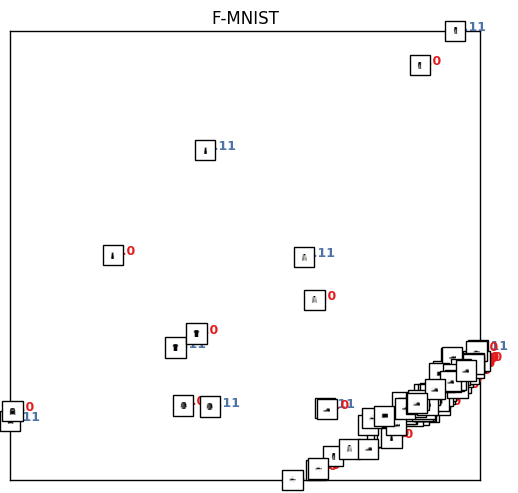

In [26]:
from sklearn import decomposition
from sklearn.manifold import TSNE
X_lyap=np.vstack([lyap_e_legit,lyap_e_adv])
image_lyap=np.vstack([X_test[idxs,:,:,0],adv[:,:,:,0]])
y_lyap=np.zeros(110)
y_lyap[0:10]=1.11# Add the .1 just to make the label standout in the image below 


X_ica = decomposition.FastICA(n_components=2).fit_transform(X_lyap)
plot_embedding_2(X_ica,y_lyap,image_lyap,
               "F-MNIST")
plt.savefig('FastICA_lyap.eps')
plt.tight_layout()
plt.show()


100%|██████████| 10/10 [01:37<00:00,  9.89s/it]


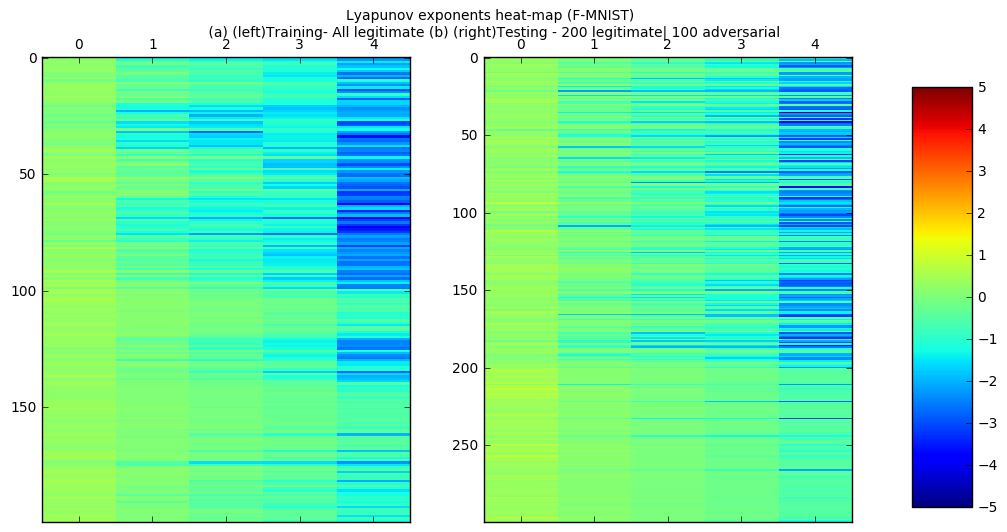

In [20]:
y_train=np.argmax(Y_train,axis=1)
#########
n_train=20
begin_ind=np.max(idxs)+1 # Just to ensure there is no overlap
X_lyap_train=np.zeros((10*n_train,DIM_MATRIX))
X_lyap_test_pos=np.zeros((10*n_train,DIM_MATRIX))
for fashion_digit in tqdm(range(10)):
    index_fashion_digit=np.where(y_train[0:2000]==fashion_digit)[0]
    ind_fashion_digit=np.random.choice(index_fashion_digit[index_fashion_digit>begin_ind],n_train)
    for i,ind in enumerate(ind_fashion_digit):
        X_lyap_train[n_train*fashion_digit+i,:]=lyap_e(X_train[ind,:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX)
        X_lyap_test_pos[n_train*fashion_digit+i,:]=lyap_e(X_test[ind,:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX)
#################################
X_lyap_test_neg=lyap_e_adv.copy()
X_lyap_test=np.vstack([X_lyap_test_pos,X_lyap_test_neg])
################################
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
ax=axes.flat[0]

im = ax.matshow(X_lyap_train, vmin=-5, vmax=5,aspect='auto')

ax=axes.flat[1]
im = ax.matshow(X_lyap_test, vmin=-5, vmax=5,aspect='auto')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.suptitle('Lyapunov exponents heat-map (F-MNIST) \n (a) (left)Training- All legitimate (b) (right)Testing - 200 legitimate| 100 adversarial')
plt.savefig('heatmap_fmnist.eps')
plt.show()

# Supervised classification (with only positive examples)
## Using the Iso-forest outlier detector.

In [25]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
clf = svm.OneClassSVM(kernel='rbf',nu=0.25,gamma=0.15)
clf.fit(X_lyap_train)
adv_detect=clf.predict(X_lyap_test)
y_true=np.ones(300)
y_true[200:]=-1
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,adv_detect)

array([[ 88,  12],
       [ 52, 148]])

# How far from the hyper-plane were the False alarms?

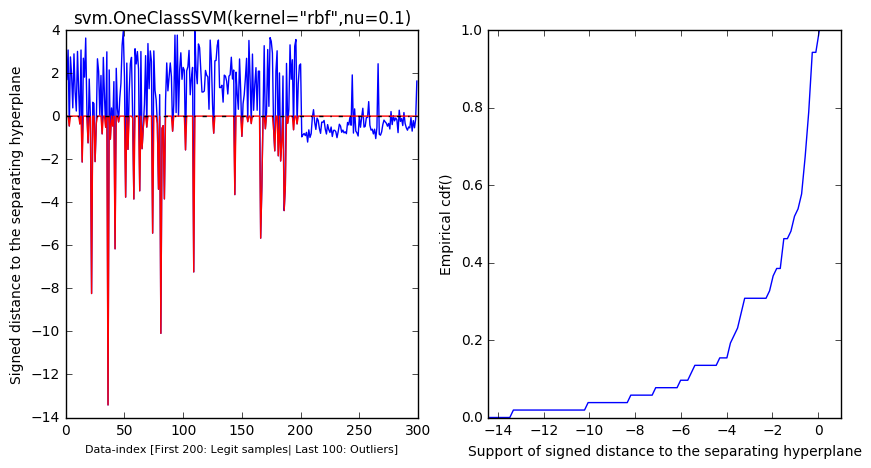

In [22]:
dist_test=clf.decision_function(X_lyap_test)

false_alarm_ind=np.intersect1d(np.where(y_true==+1),np.where(adv_detect==-1))
false_alarm_dist=np.zeros((300,1))
false_alarm_dist[false_alarm_ind]=dist_test[false_alarm_ind]
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dist_test)
plt.plot(false_alarm_dist,'r')
plt.plot(np.zeros(300),'-.k')
plt.xlabel('Data-index [First 200: Legit samples| Last 100: Outliers]',fontsize=8)
plt.ylabel('Signed distance to the separating hyperplane')
plt.title('svm.OneClassSVM(kernel="rbf",nu=0.1)')

########################################

def plt_cdf(array_in,xlabel='Support of input variable',ylabel='CDF(x)'):
    """
    Plot cdf of the RV whose samples are in input array
    """
    support_span=np.linspace(array_in.min()-1,array_in.max()+1,100)
    n=len(array_in)
    cdf_array=np.zeros(len(support_span))
    for i,x in enumerate(support_span):
        cdf_array[i]= (array_in<=x).sum()/np.float(n)
    plt.plot(support_span,cdf_array)
    plt.xlim([support_span.min(),support_span.max()])
    plt.ylim([0,1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return support_span,cdf_array
###########################################
plt.subplot(122)
_,_=plt_cdf(dist_test[false_alarm_ind].flatten(),xlabel='Support of signed distance to the separating hyperplane',ylabel='Empirical cdf()')
plt.savefig('osvm_dist_fmnist.eps')

# Visualizing what the flattened pseudo-time series looks like?

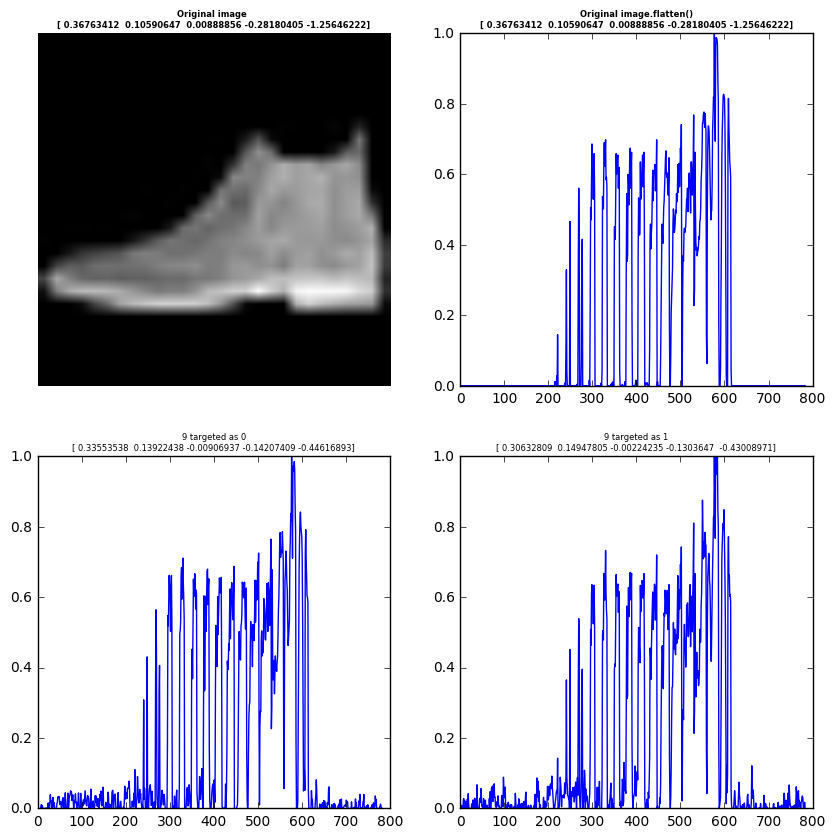

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(X_test[idxs[9],:,:,0].astype(float),cmap='gray');
plt.axis('off');
plt.title('Original image \n'+str(lyap_e(X_test[idxs[9],:,:,0].flatten().astype(float),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX)),fontweight='bold',fontsize=6)

plt.subplot(2,2,2)
plt.plot(X_test[idxs[9],:,:,0].flatten().astype(float))
plt.title('Original image.flatten()\n'+str(lyap_e(X_test[idxs[9],:,:,0].flatten().astype(float),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX)),fontweight='bold',fontsize=6)

plt.subplot(2,2,3)
i=0
plt.plot(grid_viz_data[9,i,:,:,0].flatten())
plt.title('9 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[9,i,:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX)),fontsize=6)

plt.subplot(2,2,4)
i=1
plt.plot(grid_viz_data[9,i,:,:,0].flatten())
plt.title('9 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[9,i,:,:,0].flatten(),emb_dim=DIM_EMBEDDING,matrix_dim=DIM_MATRIX)),fontsize=6)
plt.savefig('pseudo_ts_fmnist.eps')